In [2]:
import os
current_dir = %pwd
project_dir = os.path.dirname(current_dir)
%cd $project_dir

/data/dhryniewski/DataScientest/doc-classifier


/data/dhryniewski/DataScientest/doc-classifier/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import json
import time
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from joblib import load, dump
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from src import save_jsonfile, read_jsonfile, plot_search_results, Encoder

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestCentroid
from lightgbm.sklearn import LGBMClassifier
from xgboost.sklearn import XGBClassifier

/tmp/ipykernel_161311/538974212.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-07-31 09:57:22.022899: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Chargement des datasets train et test

In [4]:
df_train = pd.read_csv('data/processed/words_structure_train.csv')
df_test = pd.read_csv('data/processed/words_structure_test.csv')
seed = 42

In [5]:
df_train['words'] = df_train['words'].fillna('')
df_test['words'] = df_test['words'].fillna('')

X_train = df_train.drop('category', axis=1)
y_train = df_train['category']
X_test = df_test.drop('category', axis=1)
y_test = df_test['category']

### LabelEncoder

In [6]:
le = load("models/target_LabelEncoder.joblib")
y_train = le.transform(y_train)
y_test = le.transform(y_test)

### Tf-idf Vectorizer

In [7]:
X_train_corpus = X_train['words'].tolist()
X_test_corpus = X_test['words'].tolist()

tfidf_vectorizer = load('models/TfidfVectorizer.joblib')

X_train_tfidf = tfidf_vectorizer.transform(X_train_corpus)
X_train_tfidf = X_train_tfidf.toarray()

X_test_tfidf = tfidf_vectorizer.transform(X_test_corpus)
X_test_tfidf = X_test_tfidf.toarray()

In [8]:
def calculate_accuracy(model, X_test: np.ndarray, y_test: np.ndarray) -> dict:
    cat_dict = {
        0: "email",
        1: "handwritten",
        2: "invoice",
        3: "national_identity_card",
        4: "passeport",
        5: "scientific_publication"
    }
    category_accuracies = {}
    y_pred = model.predict(X_test)
    category_accuracies['Global'] = accuracy_score(y_test, y_pred)

    categories = np.unique(y_test)
    for category in categories:
        mask = (y_test == category)
        category_accuracy = accuracy_score(y_test[mask], y_pred[mask])
        category_accuracies[cat_dict[category]] = category_accuracy

    return category_accuracies

# Grille de Paramètres 

In [8]:
models_param_grids = {
    "NearestCentroid": {
        'metric': ['euclidean', 'manhattan'],
        'shrink_threshold': [None, 0.1, 0.5, 1.0]
    },
    "RandomForestClassifier": {
        'n_estimators': [100, 200, 300],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True],
        'oob_score': [True],
    },
    "ExtraTreesClassifier": {
        'n_estimators': [100, 200, 300],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True],
        'oob_score': [True],
    },
    "LGBMClassifier": {
        'boosting_type': ['gbdt', 'dart', 'rf'],
        'max_depth': [-1, 5, 10],
        'n_estimators': [100, 200, 300],
    },
    "LogisticRegression": {
        'penalty': ['l1', 'l2'],
        'C': [1, 10, 100, 200],
        'solver': ['liblinear', 'lbfgs'],
        'max_iter': [100, 200, 300],
    },
    "XGBClassifier": {
        'n_estimators': [100, 200, 300],
        'gamma': [0, 0.1, 0.2],
        'max_depth': [0, 5, 10],
        'subsample': [0.6, 0.8, 1.0],
    },
}

# Recherche d'hyper paramètres avec GridSearchCV

In [ ]:
cv = 5
scoring = 'accuracy'
verbose = 3
n_jobs = 5

data_results = {}
output_data_name = 'models/tfidfOnly_GridSearchCV_result.json'
data_results['seed'] = seed
data_results['GridSearchCV_params'] = {'cv':cv, 'scoring':scoring, 'verbose':verbose, 'n_jobs':n_jobs}
for model_name, param_grid in models_param_grids.items():

    print('\n', "="*100, '\n')
    print("Train:", model_name)
    print("Params Grid:", param_grid)
    data_results[model_name] = {}
    data_results[model_name]['param_grid'] = param_grid

    if model_name == "LogisticRegression":
        model = LogisticRegression(random_state=seed)
    elif model_name == "NearestCentroid":
        model = NearestCentroid()
    elif model_name == "ExtraTreesClassifier":
        model = ExtraTreesClassifier(random_state=seed)
    elif model_name == "LGBMClassifier":
        model = LGBMClassifier(objective='multiclass', random_state=seed)
    elif model_name == "XGBClassifier":
        model = XGBClassifier(objective='multi:softprob', seed=seed)
    elif model_name == "RandomForestClassifier":
        model = RandomForestClassifier(random_state=seed)

    t0 = time.time()
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring=scoring, n_jobs=n_jobs, verbose=verbose)
    grid_search.fit(X_train_tfidf, y_train)
    GridSearchCV_training_time = time.time() - t0
    print("GridSearchCV - DONE in", GridSearchCV_training_time/60, "min")
    data_results[model_name]['GridSearchCV_time'] = GridSearchCV_training_time
    data_results[model_name]['best_params'] = grid_search.best_params_
    data_results[model_name]['cv_results'] = grid_search.cv_results_
    print("Best params:", grid_search.best_params_)

    accuracy = calculate_accuracy(grid_search.best_estimator_, X_test_tfidf, y_test)
    data_results[model_name]['accuracy'] = accuracy
    print("Accuracy:\n", accuracy)

    model_filename = f"tfidfOnly_{model_name}.joblib"
    data_results[model_name]['file_name'] = model_filename
    dump(grid_search.best_estimator_, os.path.join('models', model_filename))
    save_jsonfile(output_data_name, data_results, indent=4, cls=Encoder)
    print("Model saved:", os.path.join('models', model_filename))

# Analyse de GridSearchCV

In [9]:
data_results = read_jsonfile('models/tfidfOnly_GridSearchCV_result.json')

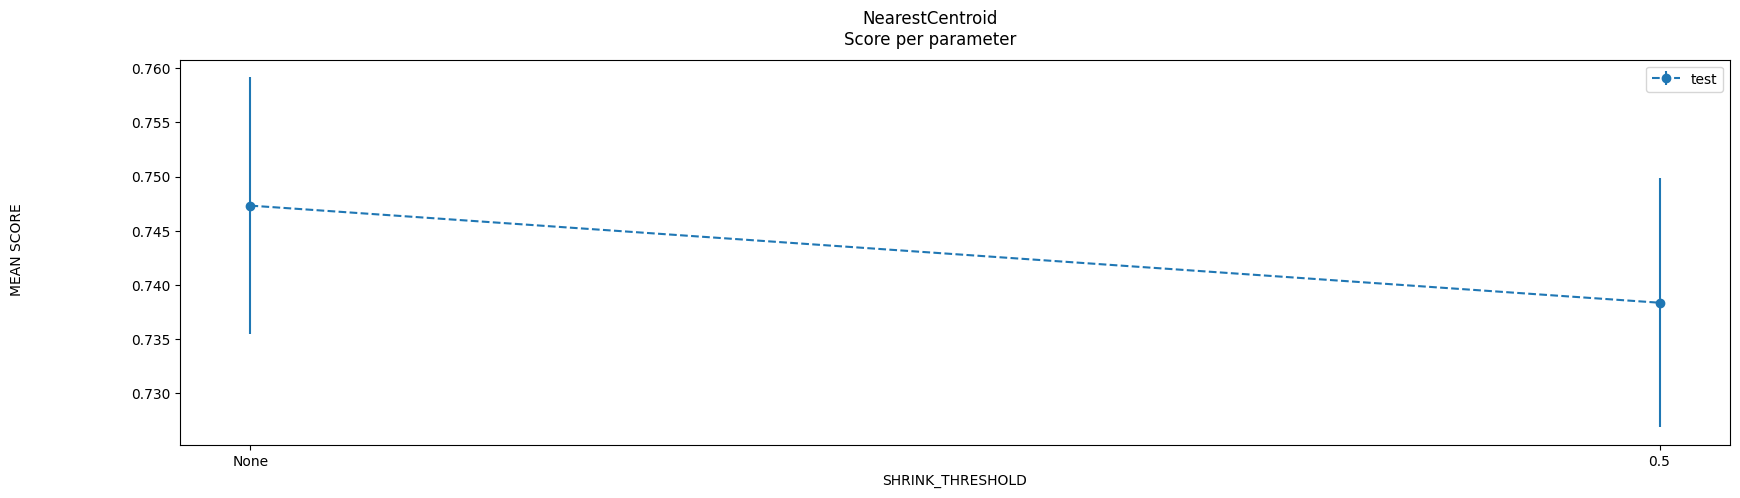

Best params: {'metric': 'euclidean', 'shrink_threshold': None}


/data/dhryniewski/DataScientest/doc-classifier/src/visualization/visualize.py:344: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  id_ = res_param['mean_test_score'].idxmax()


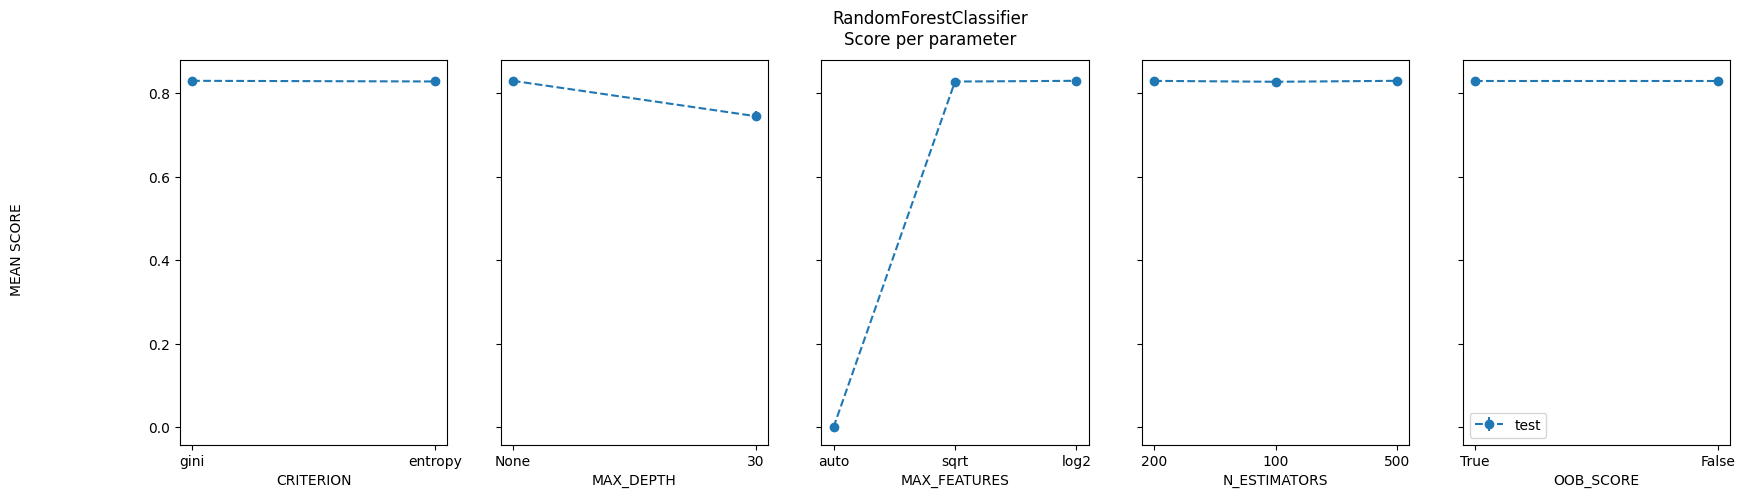

Best params: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 500, 'oob_score': True}


/data/dhryniewski/DataScientest/doc-classifier/src/visualization/visualize.py:344: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  id_ = res_param['mean_test_score'].idxmax()


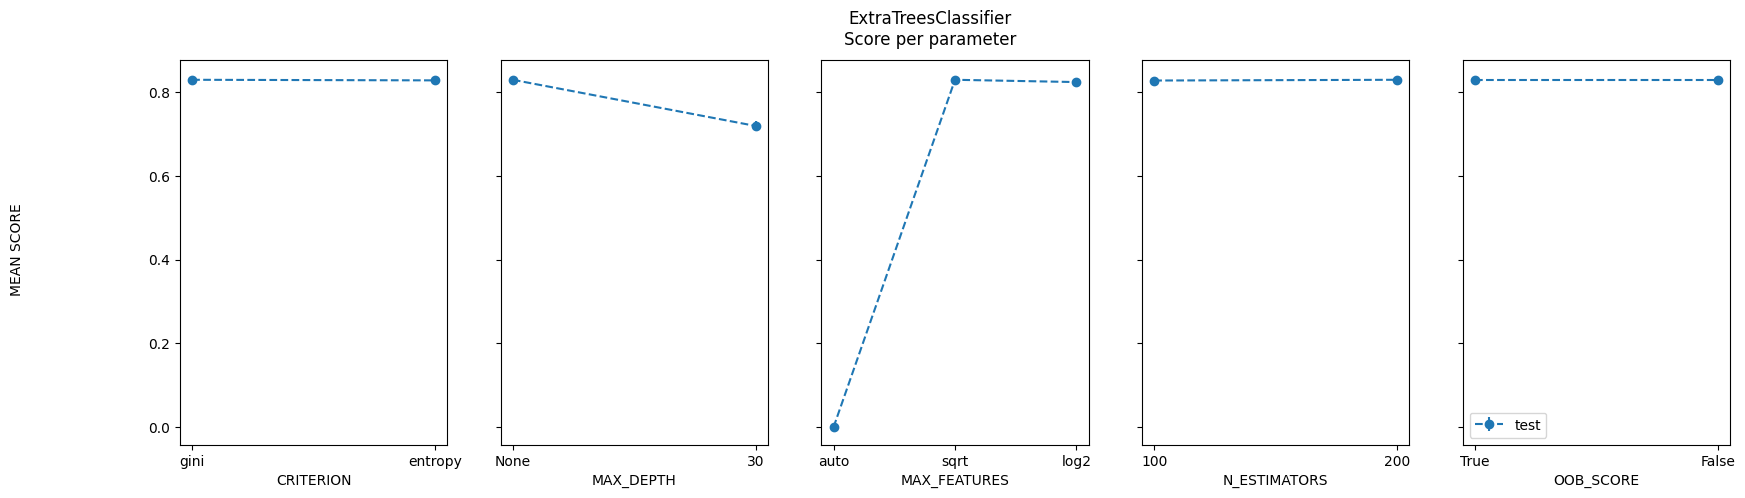

Best params: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200, 'oob_score': True}


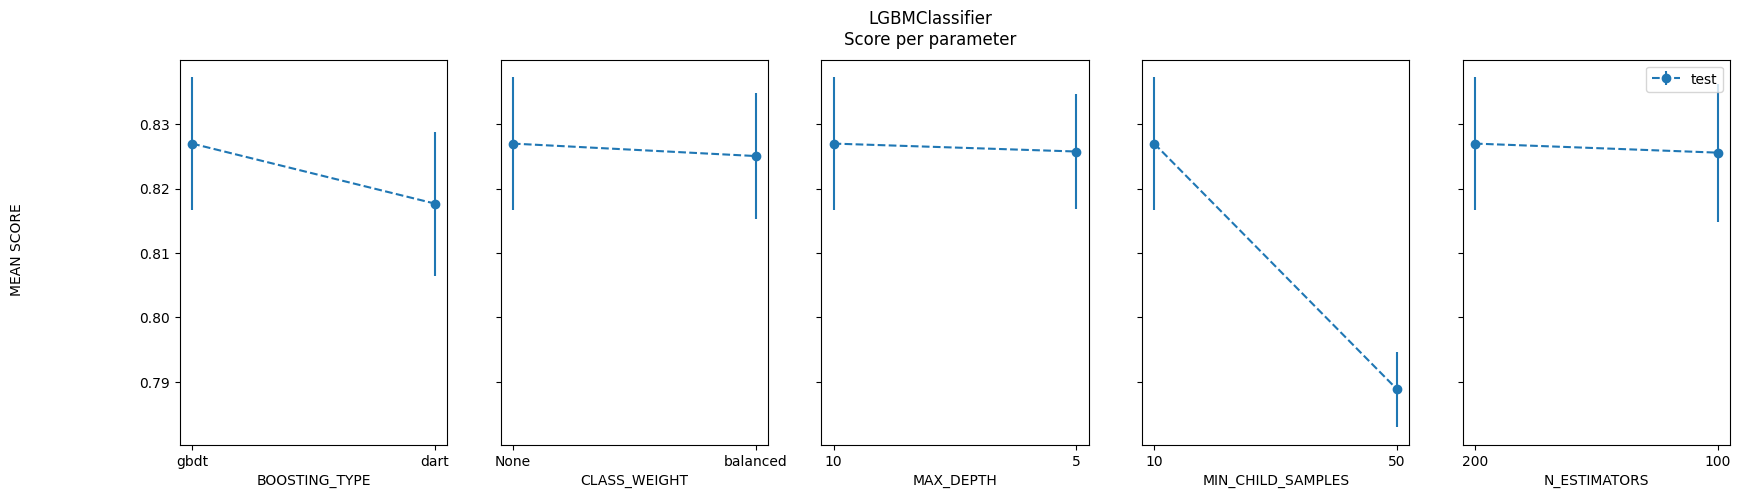

Best params: {'boosting_type': 'gbdt', 'class_weight': None, 'force_col_wise': False, 'force_row_wise': True, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_samples': 10, 'n_estimators': 200, 'num_leaves': 31}


/data/dhryniewski/DataScientest/doc-classifier/src/visualization/visualize.py:344: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  id_ = res_param['mean_test_score'].idxmax()


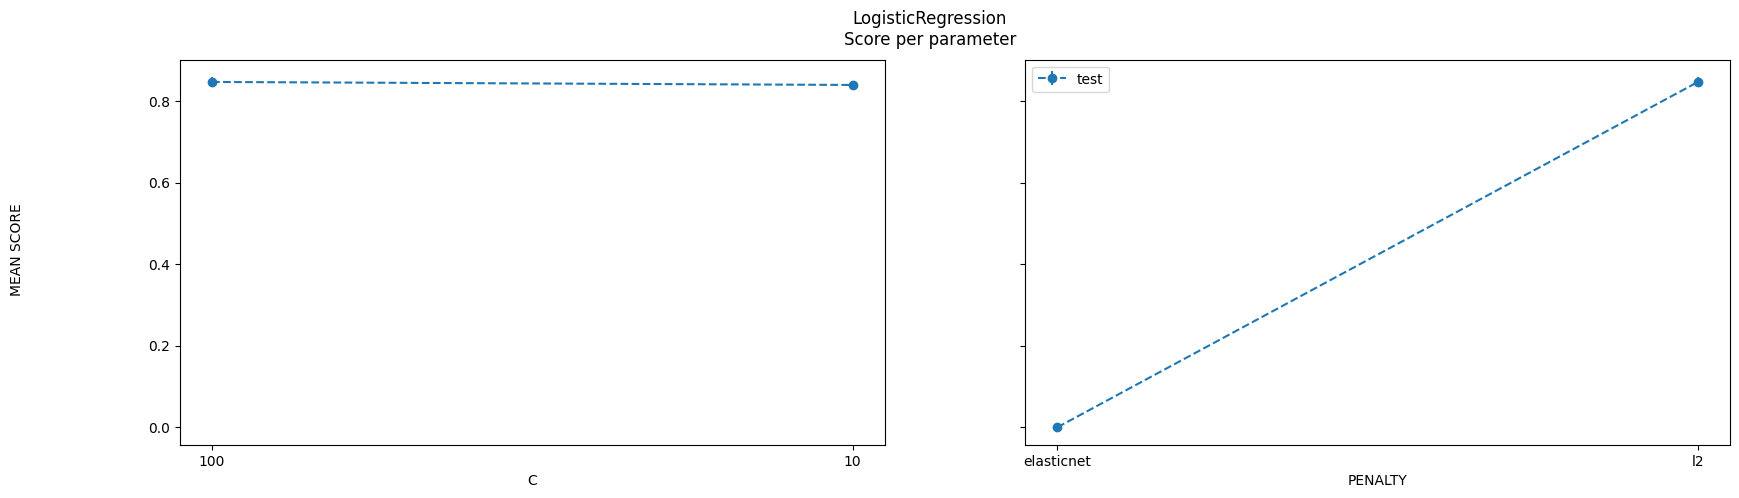

Best params: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


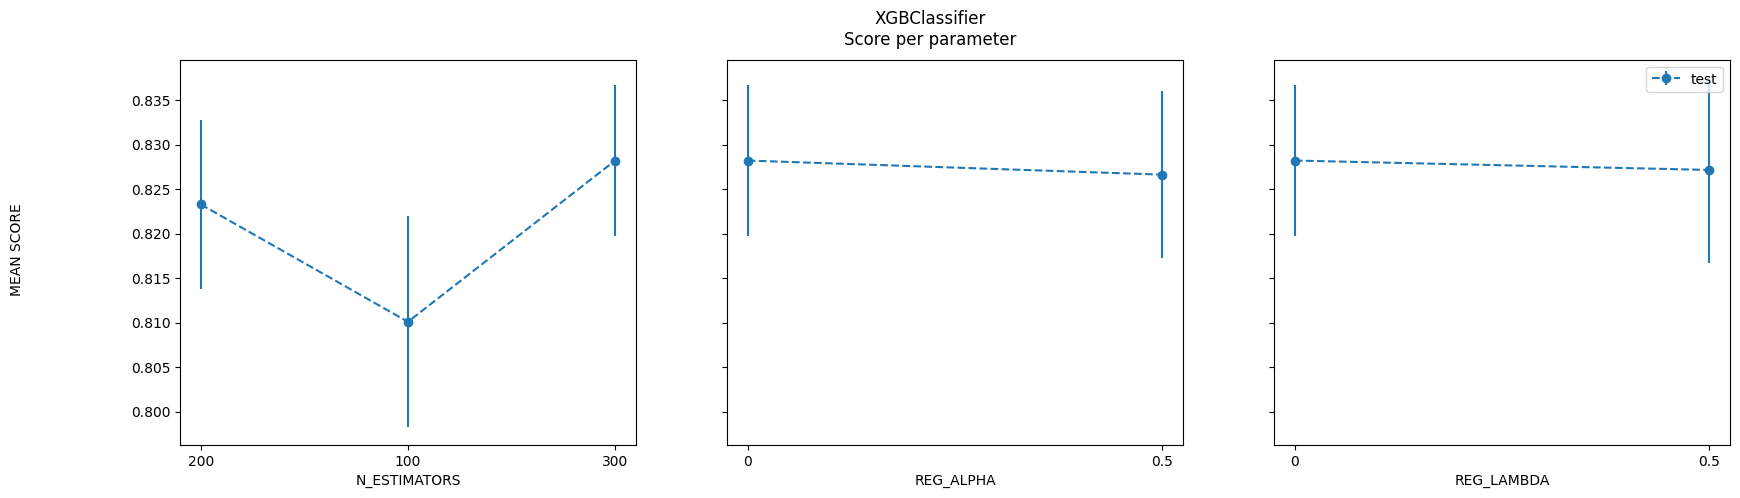

Best params: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 0}


In [10]:
models = ['NearestCentroid', 'RandomForestClassifier', 'ExtraTreesClassifier', 'LGBMClassifier', 'LogisticRegression', 'XGBClassifier']
for model_name in models:
    model_result = copy.deepcopy(data_results[model_name])
    plot_search_results(model_result['cv_results'], model_result['best_params'], model_result['param_grid'], model_name)
    print("Best params:", model_result['best_params'])
    print("="*100)

# Analyse des meilleurs résultats

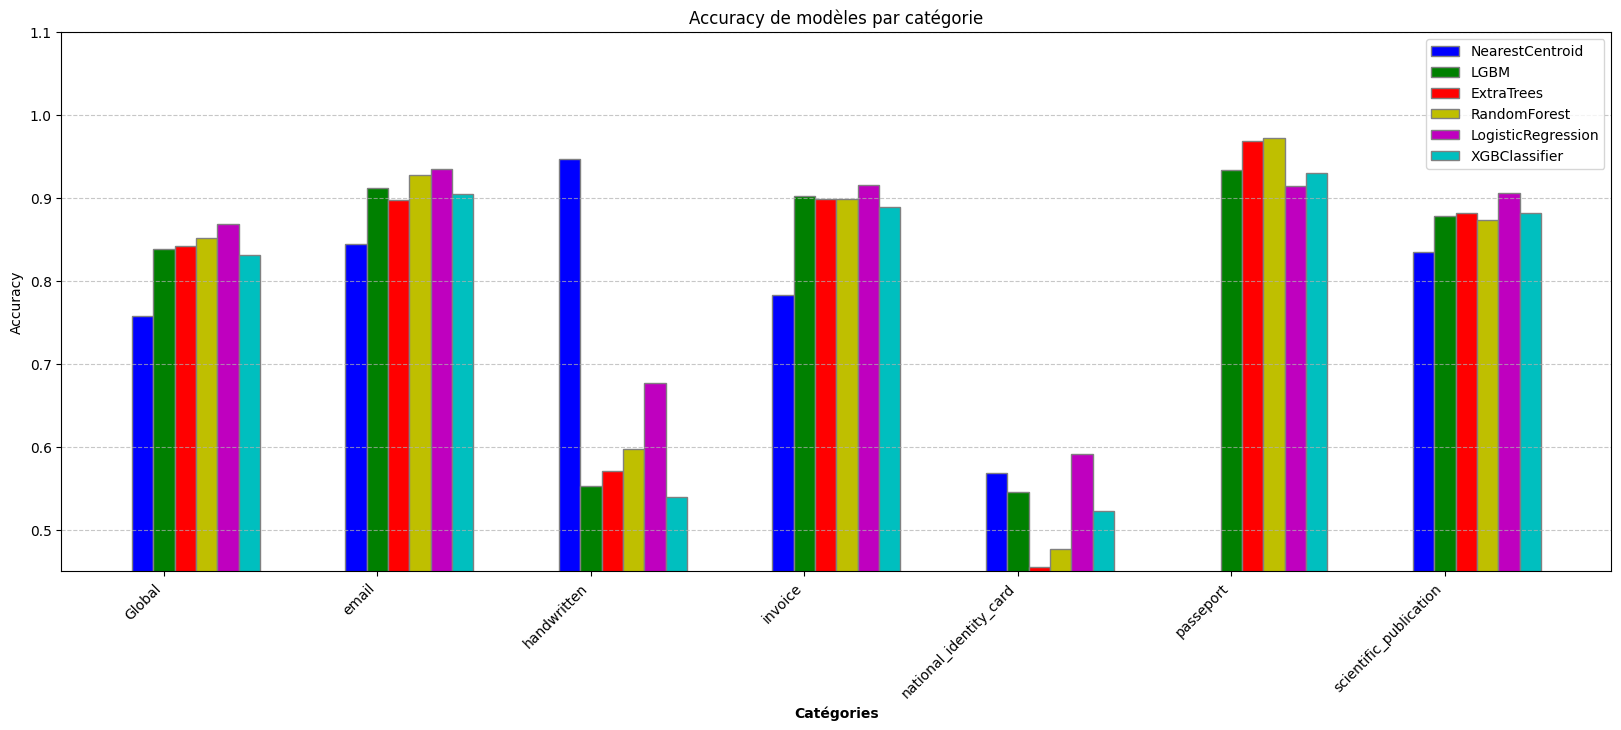

In [18]:
# Labels des catégories
categories = list(data_results['NearestCentroid']['accuracy'].keys())

# Valeurs d'accuracy pour chaque modèle
values_NearestCentroid = list(data_results['NearestCentroid']['accuracy'].values())
values_LGBM = list(data_results['LGBMClassifier']['accuracy'].values())
values_ExtraTrees = list(data_results['ExtraTreesClassifier']['accuracy'].values())
values_RandomForest = list(data_results['RandomForestClassifier']['accuracy'].values())
values_LogisticRegression = list(data_results['LogisticRegression']['accuracy'].values())
values_XGB = list(data_results['XGBClassifier']['accuracy'].values())

# Largeur des barres
bar_width = 0.1

# Positions des barres sur l'axe x
r1 = range(len(categories))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]

# Création du graphique
plt.figure(figsize=(20, 7))
plt.bar(r1, values_NearestCentroid, color='b', width=bar_width, edgecolor='grey', label='NearestCentroid')
plt.bar(r2, values_LGBM, color='g', width=bar_width, edgecolor='grey', label='LGBM')
plt.bar(r3, values_ExtraTrees, color='r', width=bar_width, edgecolor='grey', label='ExtraTrees')
plt.bar(r4, values_RandomForest, color='y', width=bar_width, edgecolor='grey', label='RandomForest')
plt.bar(r5, values_LogisticRegression, color='m', width=bar_width, edgecolor='grey', label='LogisticRegression')
plt.bar(r6, values_XGB, color='c', width=bar_width, edgecolor='grey', label='XGBClassifier')

plt.xlabel('Catégories', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(categories))], categories)
plt.ylabel('Accuracy')
plt.title('Accuracy de modèles par catégorie')

plt.legend()
plt.ylim(0.45,1.1)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# VotingClassifier

In [10]:
from sklearn.ensemble import VotingClassifier

estimators_hard = [
    ('NearestCentroid', load('models/tfidfOnly_NearestCentroid.joblib')),
    ('LogisticRegression', load('models/tfidfOnly_LogisticRegression.joblib')),
    ('RandomForest', load('models/tfidfOnly_RandomForestClassifier.joblib')),
    ('ExtraTrees', load('models/tfidfOnly_ExtraTreesClassifier.joblib')),
    ('LGBM', load('models/tfidfOnly_LGBMClassifier.joblib')),
    ('XGB', load('models/tfidfOnly_XGBClassifier.joblib')),
]

estimators_soft = [
    #('NearestCentroid', load('models/tfidfOnly_NearestCentroid.joblib')),
    ('LogisticRegression', load('models/tfidfOnly_LogisticRegression.joblib')),
    ('RandomForest', load('models/tfidfOnly_RandomForestClassifier.joblib')),
    ('ExtraTrees', load('models/tfidfOnly_ExtraTreesClassifier.joblib')),
    ('LGBM', load('models/tfidfOnly_LGBMClassifier.joblib')),
    ('XGB', load('models/tfidfOnly_XGBClassifier.joblib')),
]

voting_hard = VotingClassifier(estimators_hard, voting='hard', n_jobs=16)
voting_soft = VotingClassifier(estimators_soft, voting='soft', n_jobs=16)

print("traing voting_hard...")
voting_hard.fit(X_train_tfidf, y_train)
print("traing voting_soft...")
voting_soft.fit(X_train_tfidf, y_train)


traing voting_hard...
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Total Bins 77575
[LightGBM] [Info] Number of data points in the train set: 5687, number of used features: 4795
[LightGBM] [Info] Start training from score -1.751268
[LightGBM] [Info] Start training from score -1.714466
[LightGBM] [Info] Start training from score -1.406723
[LightGBM] [Info] Start training from score -3.648726
[LightGBM] [Info] Start training from score -1.608032
[LightGBM] [Info] Start training from score -1.742191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

/data/dhryniewski/DataScientest/doc-classifier/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


traing voting_soft...
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Total Bins 77575
[LightGBM] [Info] Number of data points in the train set: 5687, number of used features: 4795
[LightGBM] [Info] Start training from score -1.751268
[LightGBM] [Info] Start training from score -1.714466
[LightGBM] [Info] Start training from score -1.406723
[LightGBM] [Info] Start training from score -3.648726
[LightGBM] [Info] Start training from score -1.608032
[LightGBM] [Info] Start training from score -1.742191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

/data/dhryniewski/DataScientest/doc-classifier/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('LogisticRegression',
                              LogisticRegression(C=100, random_state=42)),
                             ('RandomForest',
                              RandomForestClassifier(max_features='log2',
                                                     min_samples_split=5,
                                                     n_estimators=500,
                                                     oob_score=True,
                                                     random_state=42)),
                             ('ExtraTrees',
                              ExtraTreesClassifier(bootstrap=True,
                                                   n_estimators=200,
                                                   oob_score=True,
                                                   random_state=42)),
                             ('LGBM',
                              LGBMClassifier(forc...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=300, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...))],
                 n_jobs=16, voting='soft')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


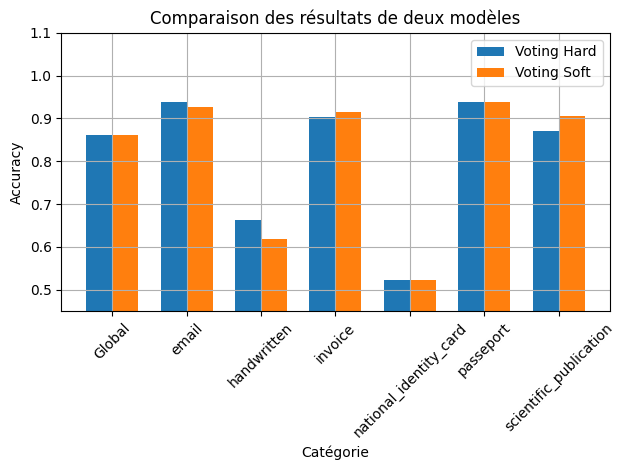

In [11]:
accuracy_voting_hard = calculate_accuracy(voting_hard, X_test_tfidf, y_test)
accuracy_voting_soft = calculate_accuracy(voting_soft, X_test_tfidf, y_test)


categories = list(accuracy_voting_hard.keys())
accuracy_hard = list(accuracy_voting_hard.values())
accuracy_soft = list(accuracy_voting_soft.values())

x = range(len(categories))
width = 0.35

plt.bar(x, accuracy_hard, width, label='Voting Hard')
plt.bar([i + width for i in x], accuracy_soft, width, label='Voting Soft')

plt.xlabel('Catégorie')
plt.ylabel('Accuracy')
plt.title('Comparaison des résultats de deux modèles')
plt.xticks([i + width/2 for i in x], categories, rotation=45)
plt.legend()
plt.ylim(0.45,1.1)
plt.grid()
plt.tight_layout()
plt.show()

In [12]:
model_vc_name = "tfidfOnly_VotingClassifier.joblib"
dump(voting_hard, os.path.join('models', model_vc_name))

['models/tfidfOnly_VotingClassifier.joblib']

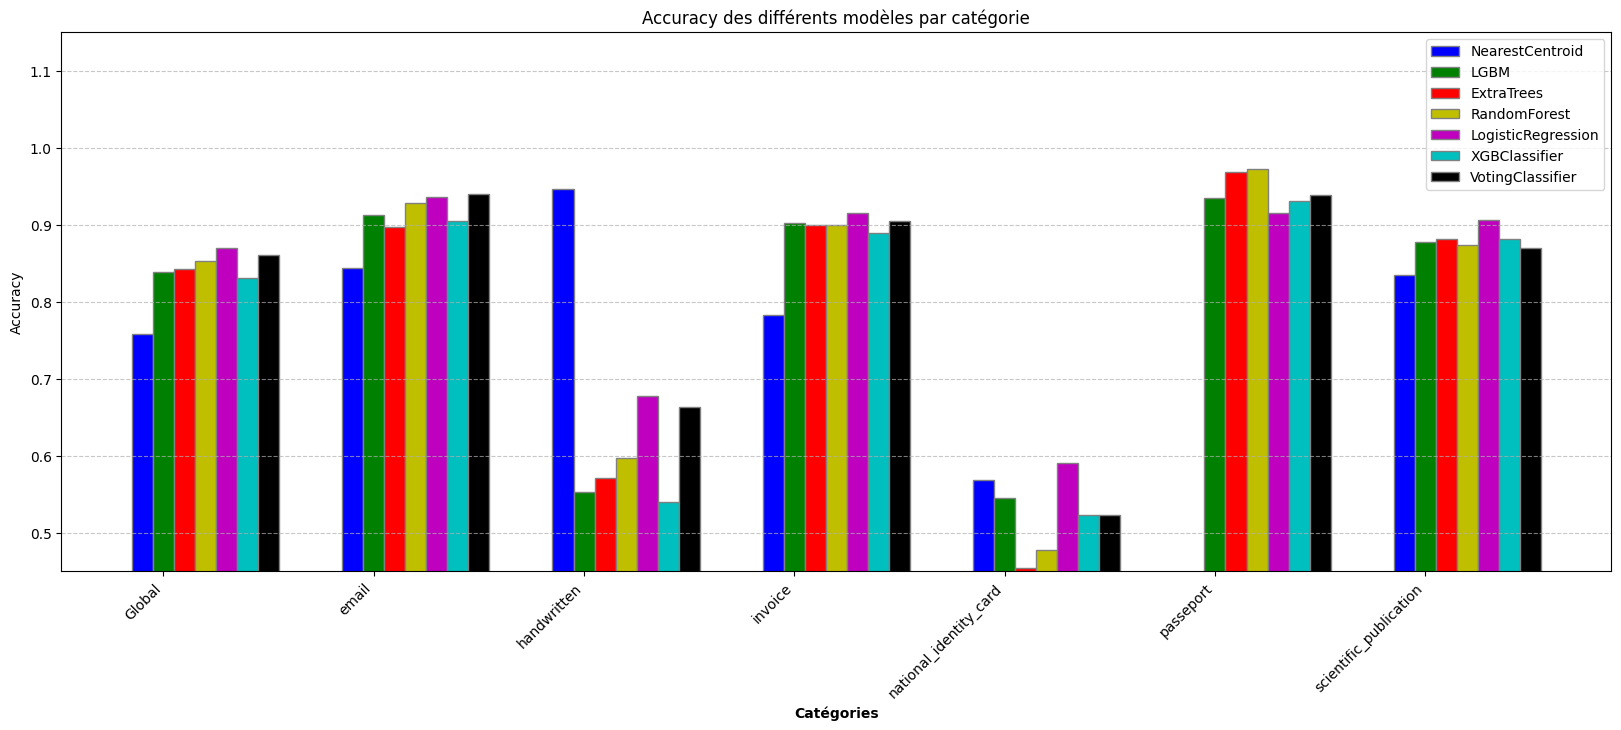

In [19]:
values_voting_hard = list(accuracy_voting_hard.values())

r7 = [x + bar_width for x in r6]

# Création du graphique
plt.figure(figsize=(20, 7))
plt.bar(r1, values_NearestCentroid, color='b', width=bar_width, edgecolor='grey', label='NearestCentroid')
plt.bar(r2, values_LGBM, color='g', width=bar_width, edgecolor='grey', label='LGBM')
plt.bar(r3, values_ExtraTrees, color='r', width=bar_width, edgecolor='grey', label='ExtraTrees')
plt.bar(r4, values_RandomForest, color='y', width=bar_width, edgecolor='grey', label='RandomForest')
plt.bar(r5, values_LogisticRegression, color='m', width=bar_width, edgecolor='grey', label='LogisticRegression')
plt.bar(r6, values_XGB, color='c', width=bar_width, edgecolor='grey', label='XGBClassifier')
plt.bar(r7, values_voting_hard, color='k', width=bar_width, edgecolor='grey', label='VotingClassifier')

plt.xlabel('Catégories', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(categories))], categories)
plt.ylabel('Accuracy')
plt.title('Accuracy des différents modèles par catégorie')

plt.legend()
plt.ylim(0.45,1.15)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [13]:
data_results["VotingClassifier"] = {'accuracy': accuracy_voting_hard}
save_jsonfile('models/tfidfOnly_GridSearchCV_result.json', data_results, indent=4)